# Optimum Multi-Parameter Analysis

This notebook is intended to run an OMP analysis of the RU36 March 2022 dataset to investigate relative contributions of different source water types.


In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import math
import xarray as xr
import dask.array as da
from erddapy import ERDDAP
import gsw
import sys
import pyompa


def get_erddap_dataset(ds_id, server, variables=None, constraints=None, filetype=None):
    """
    Returns a netcdf dataset for a specified dataset ID (or dataframe if dataset cannot be converted to xarray)
    :param ds_id: dataset ID e.g. ng314-20200806T2040
    :param variables: optional list of variables
    :param constraints: optional list of constraints
    :param filetype: optional filetype to return, 'nc' (default) or 'dataframe'
    :return: netcdf dataset
    """
    variables = variables or None
    constraints = constraints or None
    filetype = filetype or 'nc'
    #ioos_url = 'https://data.ioos.us/gliders/erddap'


    e = ERDDAP(server,
               protocol='tabledap',
               response='nc')
    e.dataset_id = ds_id
    if constraints:
        e.constraints = constraints
    if variables:
        e.variables = variables
    if filetype == 'nc':
        try:
            ds = e.to_xarray()
            ds = ds.sortby(ds.time)
        except OSError:
            print('No dataset available for specified constraints: {}'.format(ds_id))
            ds = []
        except TypeError:
            print('Cannot convert to xarray, providing dataframe: {}'.format(ds_id))
            ds = e.to_pandas().dropna()
    elif filetype == 'dataframe':
        #ds = e.to_pandas().dropna()
        ds = e.to_pandas().dropna(how='all')
    else:
        print('Unrecognized filetype: {}. Needs to  be "nc" or "dataframe"'.format(filetype))

    return ds


nan

## Load in glider data

In [200]:
ds_id = 'ru36-20220223T1807-profile-sci-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'pressure','density','potential_temperature', 'salinity','oxygen_concentration','source_file']
sci_gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
sci_gdf.columns = variables

## Great way to find start and end times!!
start_times_sci = sci_gdf.groupby('source_file').first().time.values
end_times_sci   = sci_gdf.groupby('source_file').last().time.values

## Add a column of mass=1 for OMP function constraint
sci_gdf["mass"] = 1.0

## QUICK ROUGH QC ON GLIDER DATA
sci_gdf.density[sci_gdf.density>1050] = np.NaN
sci_gdf.potential_temperature[sci_gdf.potential_temperature>50] = np.NaN
sci_gdf.salinity[sci_gdf.salinity>50] = np.NaN
sci_gdf.oxygen_concentration[sci_gdf.oxygen_concentration>300] = np.NaN
## Convert oxygen concentration from micromoles/L to ml/L
sci_gdf.oxygen_concentration = sci_gdf.oxygen_concentration/44.659
## From Anderraa Manual for umol/L (uM) to mg/l 
#sci_gdf.oxygen_concentration = sci_gdf.oxygen_concentration/31.25


## Want to use potential_density instead of in situ density
sci_gdf["sigma_theta"] = gsw.density.rho(sci_gdf.salinity.values, sci_gdf.potential_temperature.values, 0)

sci_gdf

/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

,depth,latitude,longitude,time,pressure,density,potential_temperature,salinity,oxygen_concentration,source_file,mass,sigma_theta
0,0.104071,18.178870,-64.933555,2022-02-23T18:07:57.02Z,0.1047,1023.53357,26.256176,35.767017,6.491616,ru36-2022-053-3-0-dbd(00290000),1.0,1023.399601
1,NaN,18.178870,-64.933555,2022-02-23T18:07:57.06Z,NaN,NaN,NaN,NaN,NaN,ru36-2022-053-3-0-dbd(00290000),1.0,NaN
2,NaN,18.178869,-64.933557,2022-02-23T18:07:58.02Z,NaN,NaN,NaN,NaN,NaN,ru36-2022-053-3-0-dbd(00290000),1.0,NaN
3,0.149199,18.178868,-64.933560,2022-02-23T18:07:59.11Z,0.1501,1023.53620,26.253866,35.769306,NaN,ru36-2022-053-3-0-dbd(00290000),1.0,1023.402018
4,NaN,18.178867,-64.933563,2022-02-23T18:08:00.11Z,NaN,NaN,NaN,NaN,NaN,ru36-2022-053-3-0-dbd(00290000),1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4056473,NaN,18.145213,-64.805180,2022-03-16T23:54:00.38Z,NaN,NaN,NaN,NaN,NaN,ru36-2022-074-1-2-dbd(00490002),1.0,NaN
4056474,1.523496,18.145215,-64.805179,2022-03-16T23:54:01.38Z,1.5327,1023.48846,26.388054,35.754436,6.369408,ru36-2022-074-1-2-dbd(00490002),1.0,1023.348751
4056475,NaN,18.145215,-64.805179,2022-03-16T23:54:01.62Z,NaN,NaN,NaN,NaN,NaN,ru36-2022-074-1-2-dbd(00490002),1.0,NaN
4056476,1.326785,18.145216,-64.805178,2022-03-16T23:54:02.38Z,1.3348,1023.49146,26.378600,35.755497,NaN,ru36-2022-074-1-2-dbd(00490002),1.0,1023.352518


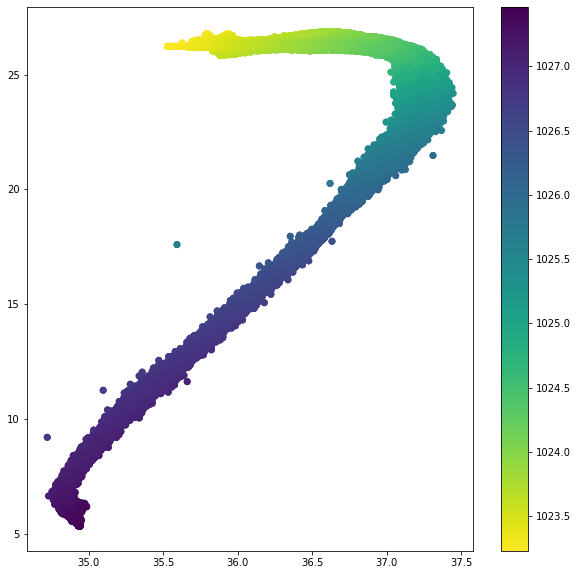

In [66]:
plt.figure(figsize=(10,10))
plt.scatter(sci_gdf.salinity,sci_gdf.potential_temperature, c=sci_gdf.sigma_theta, cmap='viridis_r')
plt.colorbar()

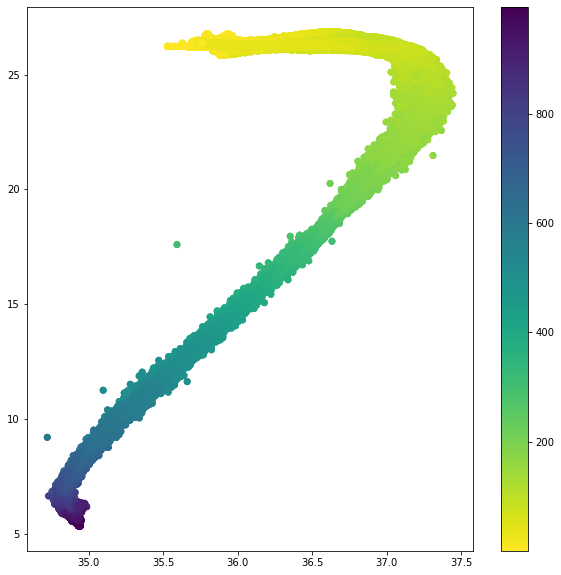

In [67]:
plt.figure(figsize=(10,10))
plt.scatter(sci_gdf.salinity,sci_gdf.potential_temperature, c=sci_gdf.depth, cmap='viridis_r')
plt.colorbar()

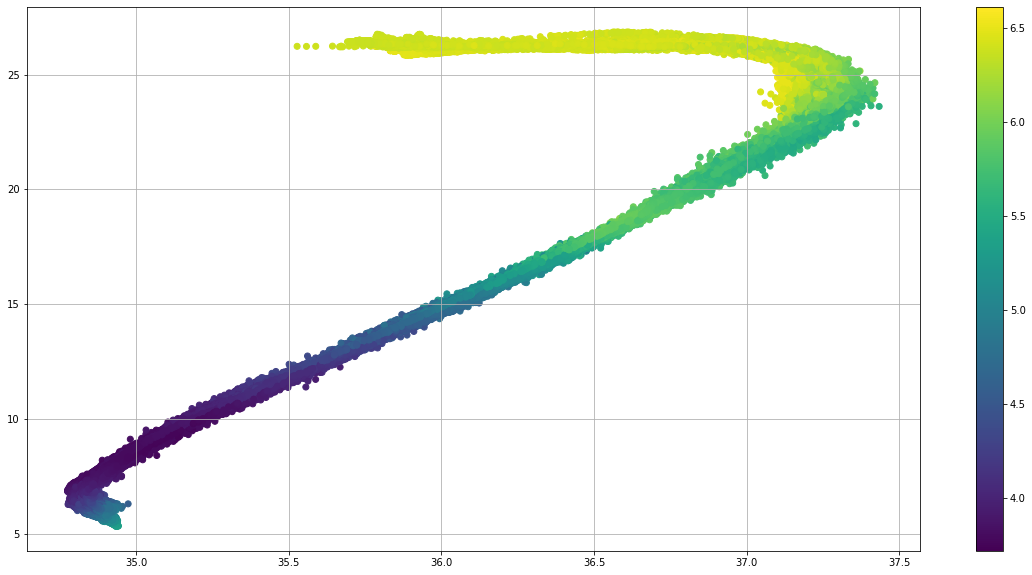

In [201]:
plt.figure(figsize=(20,10))
plt.scatter(sci_gdf.salinity[::10],sci_gdf.potential_temperature[::10], c=sci_gdf.oxygen_concentration[::10], cmap='viridis')
plt.grid()
plt.colorbar()

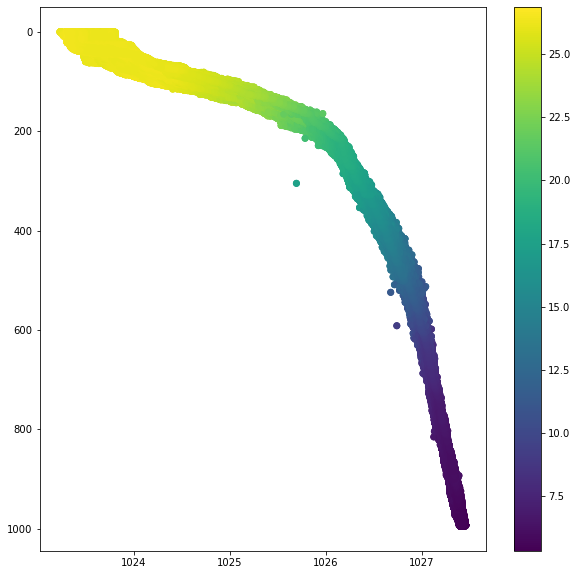

In [68]:
plt.figure(figsize=(10,10))
plt.scatter(sci_gdf.sigma_theta,sci_gdf.depth, c=sci_gdf.potential_temperature)
plt.gca().invert_yaxis()
plt.colorbar()

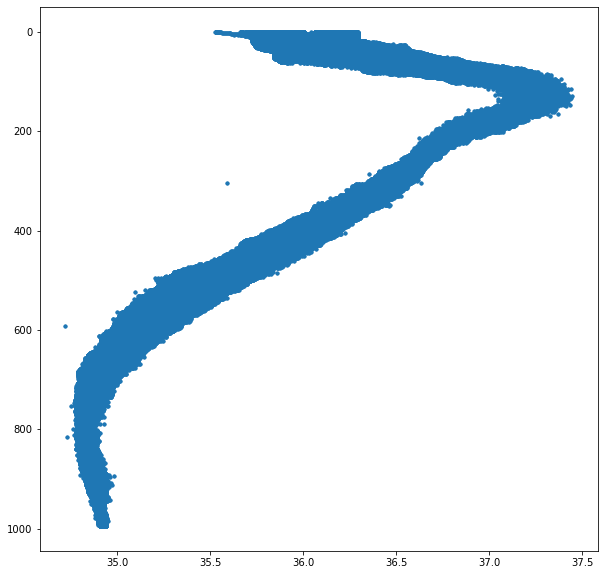

In [6]:
plt.figure(figsize=(10,10))
plt.plot(sci_gdf.salinity,sci_gdf.depth,'.')
plt.gca().invert_yaxis()


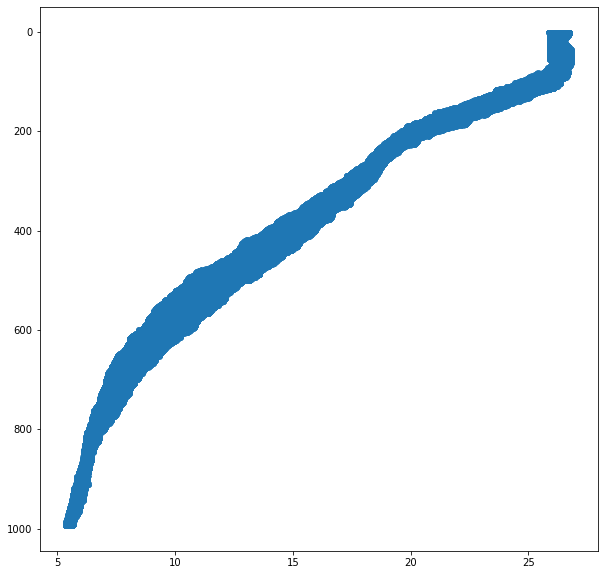

In [7]:
plt.figure(figsize=(10,10))
plt.plot(sci_gdf.potential_temperature,sci_gdf.depth,'.')
plt.gca().invert_yaxis()


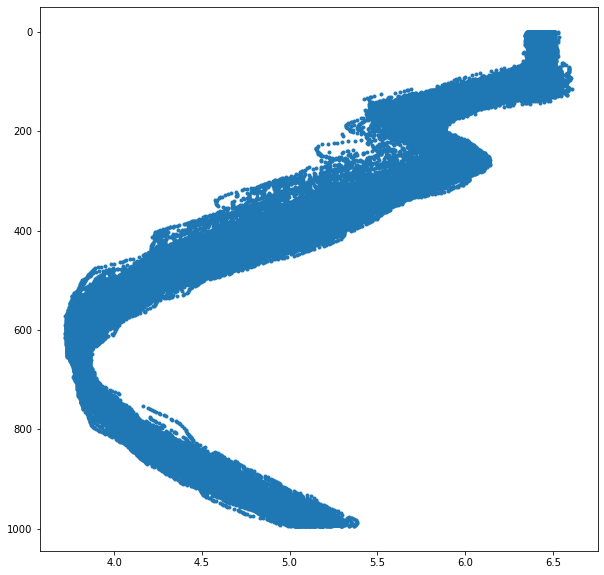

In [202]:
plt.figure(figsize=(10,10))
plt.plot(sci_gdf.oxygen_concentration[::10],sci_gdf.depth[::10],'.')
plt.gca().invert_yaxis()


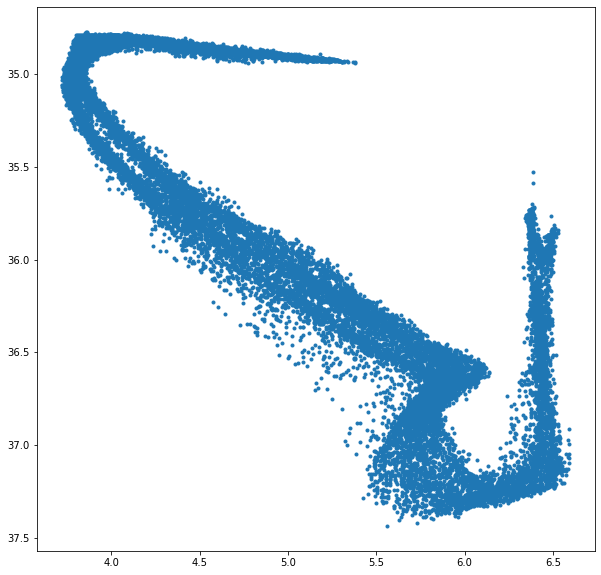

In [204]:
plt.figure(figsize=(10,10))
plt.plot(sci_gdf.oxygen_concentration[::50],sci_gdf.salinity[::50],'.')
plt.gca().invert_yaxis()


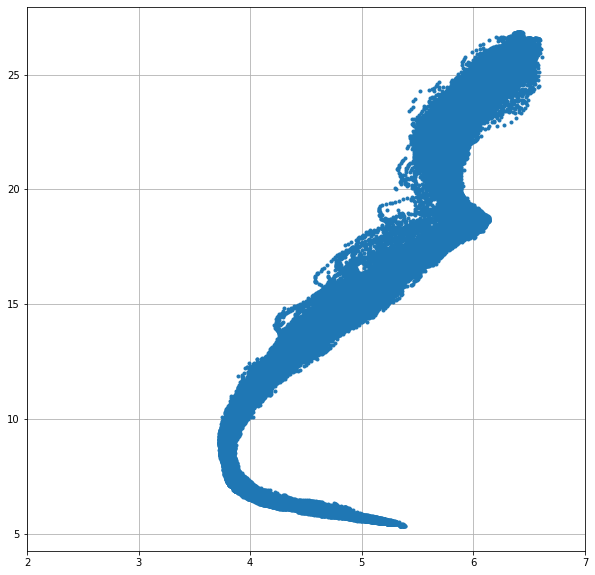

In [205]:
plt.figure(figsize=(10,10))
plt.plot(sci_gdf.oxygen_concentration[::10],sci_gdf.potential_temperature[::10],'.')
plt.xlim(2,7)
plt.grid()

Text(0, 0.5, 'Temperature (°C)')

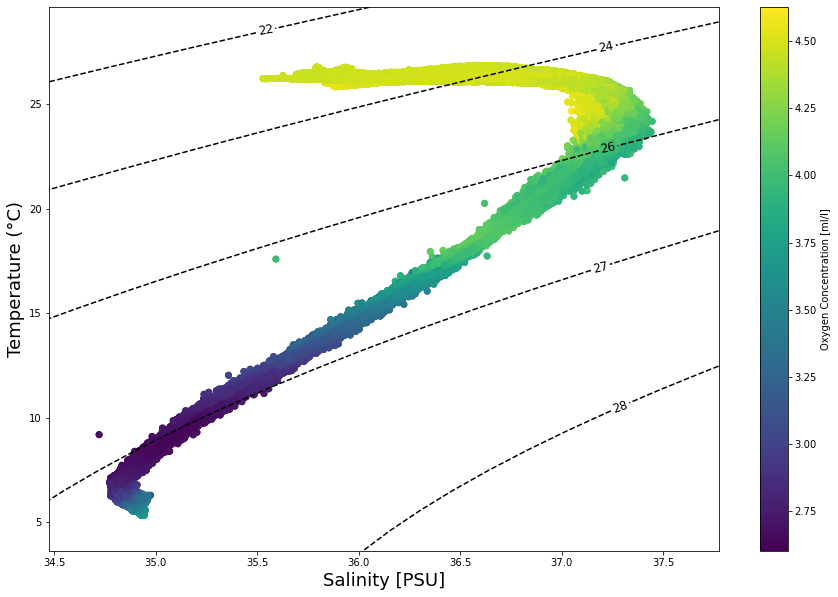

In [191]:
# Create variables with user-friendly names
temp  = sci_gdf.potential_temperature
salt  = sci_gdf.salinity
 
# Figure out boudaries (mins and maxs)
smin = salt.min() - (0.01 * salt.min())
smax = salt.max() + (0.01 * salt.max())
tmin = temp.min() - (0.1 * temp.max())
tmax = temp.max() + (0.1 * temp.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],0)
 
# Substract 1000 to convert to sigma-t
dens = dens - 1000
 

# Plot data ***********************************************
fig1 = plt.figure(figsize=(15,10))

ax1 = fig1.add_subplot(111)
CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%1.0f') # Label every second level
 
oxy = ax1.scatter(sci_gdf.salinity,sci_gdf.potential_temperature,c=sci_gdf.oxygen_concentration)
fig1.colorbar(oxy,label='Oxygen Concentration [ml/l]')
ax1.set_xlabel('Salinity [PSU]',size=18)
ax1.set_ylabel('Temperature (°C)',size=18)

## Subset glider data to different water masses by density

In [176]:
# SUW_sci_gdf = sci_gdf[(sci_gdf.density >= 1024.5) & (sci_gdf.density <= 1026)]
# MW_sci_gdf  = sci_gdf[(sci_gdf.density >= 1026) & (sci_gdf.density <= 1028)]
# IW_sci_gdf  = sci_gdf[(sci_gdf.density >= 1027.2) & (sci_gdf.density <= 1028)]
# DW_sci_gdf  = sci_gdf[(sci_gdf.density >= 1027.7)]

SUW_sci_gdf = sci_gdf[(sigma_theta >= 1024.5)  &  (sigma_theta <= 1026.5)]
#MW_sci_gdf  = sci_gdf[(sigma_theta >= 1026)    &  (sigma_theta <= 1027)]
#IDW_sci_gdf  = sci_gdf[(sigma_theta >= 1027)]
#DW_sci_gdf  = sci_gdf[(sigma_theta >= 1027)]


In [177]:
print('SUW min salinity', np.nanmin(SUW_sci_gdf.salinity))
print('SUW max salinity', np.nanmax(SUW_sci_gdf.salinity))
print('SUW min temperature', np.nanmin(SUW_sci_gdf.potential_temperature))
print('SUW max temperature', np.nanmax(SUW_sci_gdf.potential_temperature))
print('SUW min oxygen', np.nanmin(SUW_sci_gdf.oxygen_concentration))
print('SUW max oxygen', np.nanmax(SUW_sci_gdf.oxygen_concentration))
print('SUW min depth', np.nanmin(SUW_sci_gdf.depth))
print('SUW max depth', np.nanmax(SUW_sci_gdf.depth))

print('')

print('MW min salinity', np.nanmin(MW_sci_gdf.salinity))
print('MW max salinity', np.nanmax(MW_sci_gdf.salinity))
print('MW min temperature', np.nanmin(MW_sci_gdf.potential_temperature))
print('MW max temperature', np.nanmax(MW_sci_gdf.potential_temperature))
print('MW min oxygen', np.nanmin(MW_sci_gdf.oxygen_concentration))
print('MW max oxygen', np.nanmax(MW_sci_gdf.oxygen_concentration))
print('MW min depth', np.nanmin(MW_sci_gdf.depth))
print('MW max depth', np.nanmax(MW_sci_gdf.depth))

print('')

print('IW min salinity', np.nanmin(IW_sci_gdf.salinity))
print('IW max salinity', np.nanmax(IW_sci_gdf.salinity))
print('IW min temperature', np.nanmin(IW_sci_gdf.potential_temperature))
print('IW max temperature', np.nanmax(IW_sci_gdf.potential_temperature))
print('IW min oxygen', np.nanmin(IW_sci_gdf.oxygen_concentration))
print('IW max oxygen', np.nanmax(IW_sci_gdf.oxygen_concentration))
print('IW min depth', np.nanmin(IW_sci_gdf.depth))
print('IW max depth', np.nanmax(IW_sci_gdf.depth))

print('')

# print('DW min salinity', np.nanmin(DW_sci_gdf.salinity))
# print('DW max salinity', np.nanmax(DW_sci_gdf.salinity))
# print('DW min temperature', np.nanmin(DW_sci_gdf.potential_temperature))
# print('DW max temperature', np.nanmax(DW_sci_gdf.potential_temperature))
# print('DW min oxygen', np.nanmin(DW_sci_gdf.oxygen_concentration))
# print('DW max oxygen', np.nanmax(DW_sci_gdf.oxygen_concentration))
# print('DW min depth', np.nanmin(DW_sci_gdf.depth))
# print('DW max depth', np.nanmax(DW_sci_gdf.depth))

SUW min salinity 35.59143
SUW max salinity 37.44567
SUW min temperature 15.486096
SUW max temperature 26.139181
SUW min oxygen 3.2170671085335543
SUW max oxygen 4.626435880785508
SUW min depth 69.98246
SUW max depth 389.87628

MW min salinity 34.720192
MW max salinity 37.124557
MW min temperature 8.685853
MW max temperature 20.864069
MW min oxygen 2.602700463512394
MW max oxygen 4.297901878680669
MW min depth 180.5836
MW max depth 655.5282

IW min salinity 34.769783
IW max salinity 34.985264
IW min temperature 5.3297877
IW max temperature 7.195479
IW min oxygen 2.800264224456437
IW max oxygen 3.767124207886428
IW min depth 736.554
IW max depth 994.69403



In [178]:
## Ranges from Mertens/Rhein

## Northern Means
n_temp = (14.9+26.2)/2
n_sal  = (36.05+37.3)/2
n_oxy  = 3.5 ###### This is from Bourles et al. 1999 Figure 4


## Southern Means
s_temp = (10.4+23.4)/2
s_sal  = (34.9+35.9)/2
s_oxy  = 4.1 ###### This is from Bourles et al. 1999 Figure 4

## Eastern Means (South Atlantic flavor of EAW due to low oxygen)
e_temp = 16   ## Don't know about this, this is from Urbano (2008)
e_sal  = 35.5 ## This is from Wilson (1994) and Urbano (2008)
e_oxy  = 3    ## This is from Wilson (1994) and Urbano (2008)

print('Northern Mean Temp', n_temp)
print('Northern Mean Salinity', n_sal)
print('Northern Mean Oxygen', n_oxy)
print('')
print('Southern Mean Temp', s_temp)
print('Southern Mean Salinity', s_sal)
print('Southern Mean Oxygen', s_oxy)
print('')
print('Eastern Mean Temp', e_temp)
print('Eastern Mean Salinity', e_sal)
print('Eastern Mean Oxygen', e_oxy)


Northern Mean Temp 20.55
Northern Mean Salinity 36.675
Northern Mean Oxygen 3.5

Southern Mean Temp 16.9
Southern Mean Salinity 35.4
Southern Mean Oxygen 4.1

Eastern Mean Temp 16
Eastern Mean Salinity 35.5
Eastern Mean Oxygen 3


## Determine End-Members

In [179]:
#                                temp       sal      oxy
# NAW_SUW =       ["NAW_SUW",        20.55,   36.675,   3.5]    # Warmer and saltier, high oxygen
# SAW_SUW =       ["SAW_SUW",        16.9,    35.4,     4.1]       # Colder and fresher, high oxygen
# EAW_SUW =       ["EAW_SUW",        16,      35.5,     3]          # lowest oxygen
NAW_SUW =       ["NAW_SUW",        20.25,   36.84,   3.8]    # Warmer and saltier, high oxygen
SAW_SUW =       ["SAW_SUW",        18.83,    35.65,     4.1]       # Colder and fresher, high oxygen
EAW_SUW =       ["EAW_SUW",        18.5,      35.7,     2.55]          # lowest oxygen


def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "potential_temperature", "salinity", "oxygen_concentration"])
    df["mass"] = 1
    return df

subtropical_under_waters_FK_endmemberdf = prepare_endmember_df([NAW_SUW, SAW_SUW, EAW_SUW])
subtropical_under_waters_FK_endmemberdf

,endmember_name,potential_temperature,salinity,oxygen_concentration,mass
0,NAW_SUW,20.25,36.84,3.80,1
1,SAW_SUW,18.83,35.65,4.10,1
2,EAW_SUW,18.50,35.70,2.55,1


In [180]:
#                                temp       sal         oxy
ENACW  =        ["ENACW",       12.31,    35.662,        234.4*0.0295]
WNACW  =        ["WNACW",       18.03,    36.536,        204.3*0.0295]
ESACW   =       ["ESACW",       11.26,    34.944,        219.2*0.0295]
WSACW   =       ["WSACW",       14.27,    35.439,        216.0*0.0295]


def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "potential_temperature", "salinity", "oxygen_concentration"])
    df["mass"] = 1
    return df

central_waters_FK_endmemberdf = prepare_endmember_df([ENACW, WNACW, ESACW, WSACW])
central_waters_FK_endmemberdf

,endmember_name,potential_temperature,salinity,oxygen_concentration,mass
0,ENACW,12.31,35.662,6.91480,1
1,WNACW,18.03,36.536,6.02685,1
2,ESACW,11.26,34.944,6.46640,1
3,WSACW,14.27,35.439,6.37200,1


## Settings

In [181]:
#Define a parameter to represent remineralization in terms of phosphate
# The ratio of oxygen:phosphate specified is -170:1, that is 170 moles of
# oxygen consumed for each mole of oxygen produced.
convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[{"oxygen_concentration": -170, "phosphate": 1.0}],
        always_positive=True #The MATLAB OMP implementation enforces a positive
        # value for the delta P variable, meaning it can only model
        # remineralization. Change to False (the default) to also model
        # assimilation.
        )
]


paramweightings = {
    "potential_temperature": 24.0,
    "salinity": 24.0,
    "mass": 24.0,
    "oxygen_concentration": 7.0,
}

settings = {
    "param_names": ["potential_temperature", "salinity",
                    "oxygen_concentration", "mass"],
    "convertedparam_groups": convertedparamgroups,
    "param_weightings": paramweightings,
}


## Test on the whole glider data frame

In [182]:
# test_ompa_soln = pyompa.OMPAProblem(obs_df = sci_gdf, **settings).solve(central_waters_FK_endmemberdf,endmember_name_column = "endmember_name")


In [183]:
# min_range = 0
# max_range = len(test_ompa_soln.obs_df)
# #max_range=2000

# plt.figure(figsize=(20,10))
# plt.scatter(np.arange(min_range,max_range), test_ompa_soln.obs_df.depth[min_range:max_range], c=test_ompa_soln.endmember_fractions[min_range:max_range,0]*100, vmin=0,vmax=100)
# plt.gca().invert_yaxis()
# plt.colorbar(label='% ENACW')


In [184]:
# min_range = 0
# max_range = len(test_ompa_soln.obs_df)
# #max_range=2000

# plt.figure(figsize=(20,10))
# plt.scatter(np.arange(min_range,max_range), test_ompa_soln.obs_df.depth[min_range:max_range], c=test_ompa_soln.endmember_fractions[min_range:max_range,1]*100, vmin=0,vmax=100)
# plt.gca().invert_yaxis()
# plt.colorbar(label='% WNACW')


In [185]:
# min_range = 0
# max_range = len(test_ompa_soln.obs_df)
# #max_range=2000

# plt.figure(figsize=(20,10))
# plt.scatter(np.arange(min_range,max_range), test_ompa_soln.obs_df.depth[min_range:max_range], c=test_ompa_soln.endmember_fractions[min_range:max_range,2]*100, vmin=0,vmax=100)
# plt.gca().invert_yaxis()
# plt.colorbar(label='% ESACW')


In [186]:
# min_range = 0
# max_range = len(test_ompa_soln.obs_df)
# #max_range=2000

# plt.figure(figsize=(20,10))
# plt.scatter(np.arange(min_range,max_range), test_ompa_soln.obs_df.depth[min_range:max_range], c=test_ompa_soln.endmember_fractions[min_range:max_range,4]*100, vmin=0,vmax=100)
# plt.gca().invert_yaxis()
# plt.colorbar(label='% WSACW')


## SUW Fit

In [187]:
#Run the analysis, replicating the MATLAB OMP analysis
SUW_ompa_soln = pyompa.OMPAProblem(obs_df = SUW_sci_gdf, **settings).solve(subtropical_under_waters_FK_endmemberdf,endmember_name_column = "endmember_name")


Dropping 363328 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1]), ('EAW', [2])])
params to use: ['potential_temperature', 'salinity', 'oxygen_concentration', 'mass']
param weighting: [24. 24.  7. 24.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 345748 out of 345748
status: optimal
optimal value 1042222144.931412
Original weighted sum squares: 1042222144.931412
Post fix weighted sum squared: 1042225419.3260934
On example 0 to 345748 out of 345748
status: optimal
optimal value 1042222144.931412
Original weighted sum squares: 1042222144.931412
Post fix weighted sum squared: 1042225419.3260934
objective: 1042225419.3260937


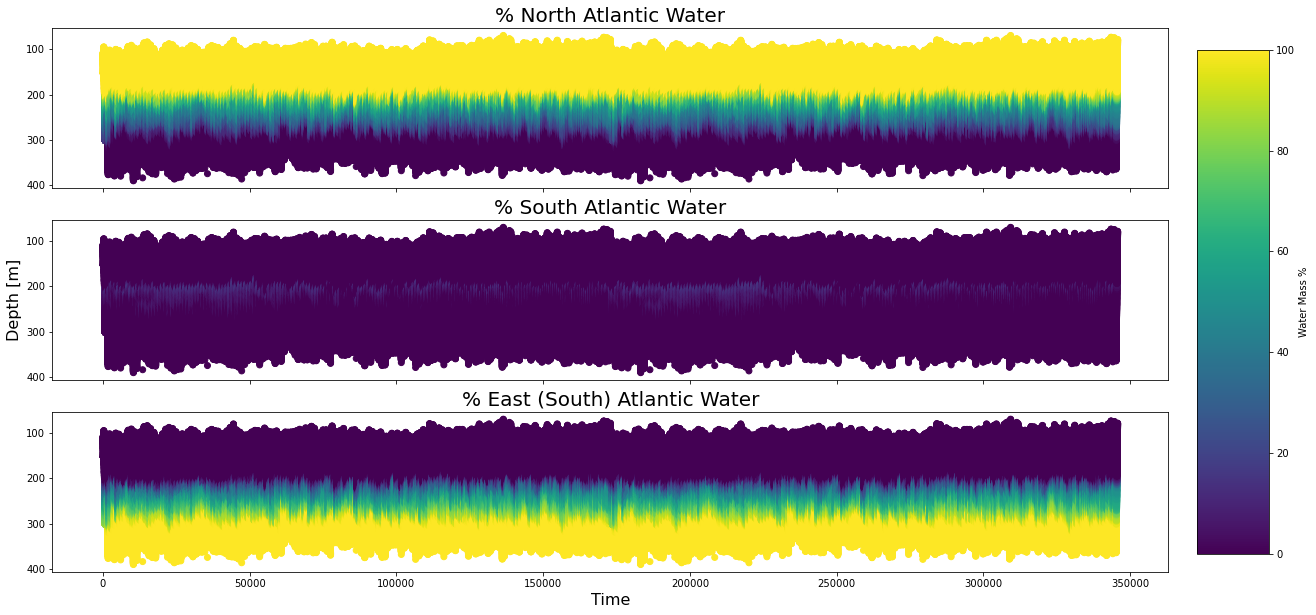

In [188]:
min_range = 0
max_range = len(SUW_ompa_soln.obs_df)

f, axes = plt.subplots(figsize=(20,10), nrows = 3, ncols = 1, sharex=True, sharey = True)

sc = axes[0].scatter(np.arange(min_range,max_range), SUW_ompa_soln.obs_df.depth[min_range:max_range], c=SUW_ompa_soln.endmember_fractions[min_range:max_range,0]*100, vmin=0,vmax=100)
axes[0].invert_yaxis()
axes[0].set_title('% North Atlantic Water', fontsize=20)

axes[1].scatter(np.arange(min_range,max_range), SUW_ompa_soln.obs_df.depth[min_range:max_range], c=SUW_ompa_soln.endmember_fractions[min_range:max_range,1]*100, vmin=0,vmax=100)
axes[1].invert_yaxis()
axes[1].set_title('% South Atlantic Water', fontsize=20)

axes[2].scatter(np.arange(min_range,max_range), SUW_ompa_soln.obs_df.depth[min_range:max_range], c=SUW_ompa_soln.endmember_fractions[min_range:max_range,2]*100, vmin=0,vmax=100)
axes[2].invert_yaxis()
axes[2].set_title('% East (South) Atlantic Water', fontsize=20)

axes[1].set_ylabel('Depth [m]', fontsize=16)
axes[2].set_xlabel('Time', fontsize=16)

cbar_ax = f.add_axes([0.92, 0.15, 0.05, 0.7])
fbar = f.colorbar(sc, cax=cbar_ax, label='Water Mass %')
#fbar.ax.set_title(fontsize=16)



In [190]:
np.nanmax(SUW_ompa_soln.endmember_fractions[min_range:max_range,1]*100)

19.154736185853285

## CW Fit

In [39]:
#Run the analysis, replicating the MATLAB OMP analysis
CW_ompa_soln = pyompa.OMPAProblem(obs_df = CW_sci_gdf, **settings).solve(central_waters_FK_endmemberdf,endmember_name_column = "endmember_name")


Dropping 91980 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('WSACW', [0]), ('ESACW', [1]), ('NACW', [2])])
params to use: ['potential_temperature', 'salinity', 'oxygen_concentration', 'mass']
param weighting: [24. 24.  7. 24.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 87214 out of 87214
status: optimal
optimal value 4846157628.051715
Original weighted sum squares: 4846157628.051715
Post fix weighted sum squared: 4846157628.197524
On example 0 to 87214 out of 87214
status: optimal
optimal value 4846157628.051715
Original weighted sum squares: 4846157628.051715
Post fix weighted sum squared: 4846157628.197524
objective: 4846157628.197524


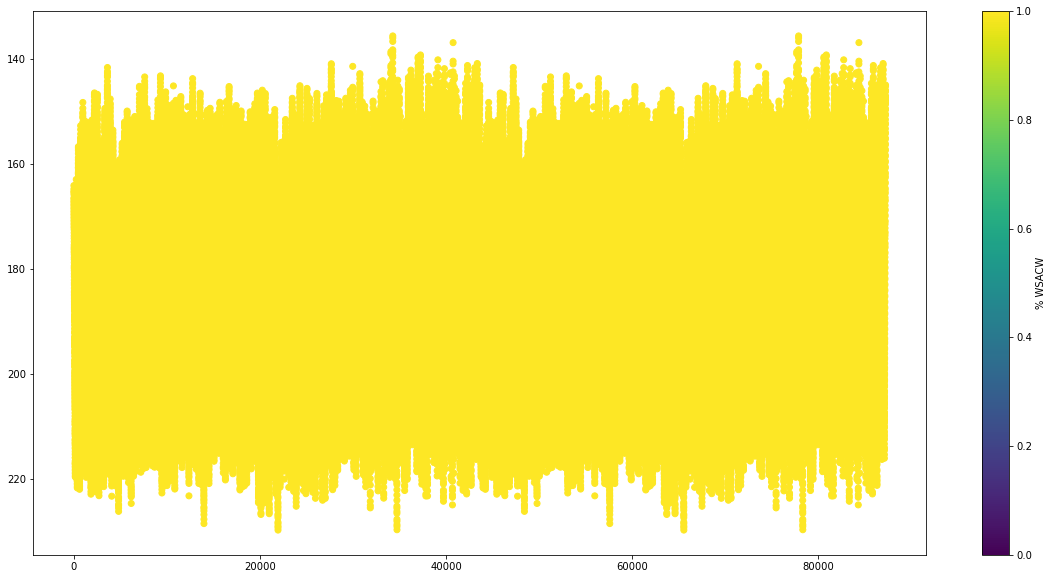

In [40]:
min_range = 0
max_range = len(CW_ompa_soln.obs_df)
#max_range=2000

plt.figure(figsize=(20,10))
plt.scatter(np.arange(min_range,max_range), CW_ompa_soln.obs_df.depth[min_range:max_range], c=CW_ompa_soln.endmember_fractions[min_range:max_range,0], vmin=0,vmax=1)
plt.gca().invert_yaxis()
plt.colorbar(label='% WSACW')


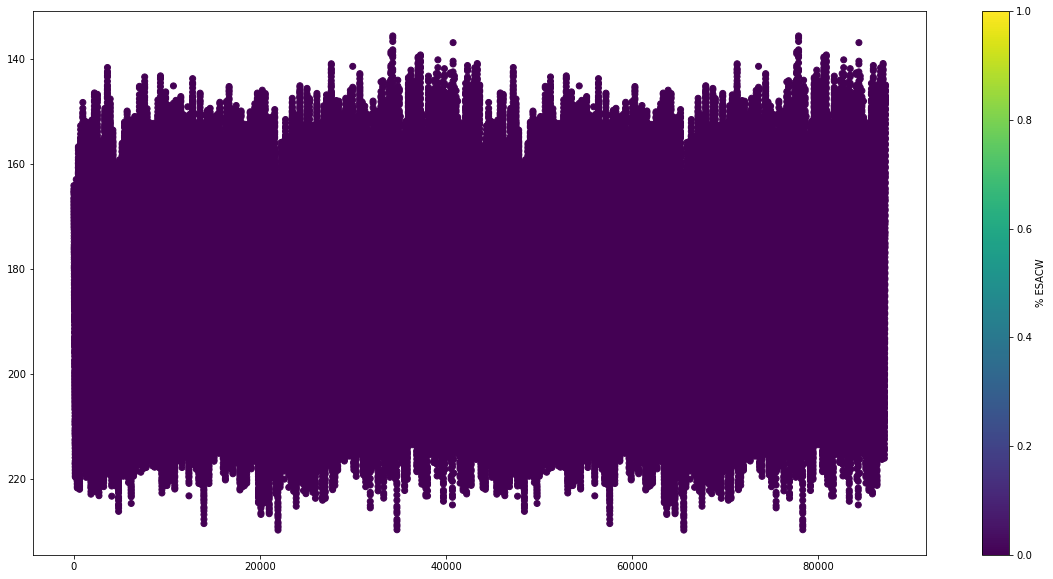

In [41]:
min_range = 0
max_range = len(CW_ompa_soln.obs_df)
#max_range=2000


plt.figure(figsize=(20,10))
plt.scatter(np.arange(min_range,max_range), CW_ompa_soln.obs_df.depth[min_range:max_range], c=CW_ompa_soln.endmember_fractions[min_range:max_range,1], vmin=0,vmax=1)
plt.gca().invert_yaxis()
plt.colorbar(label='% ESACW')




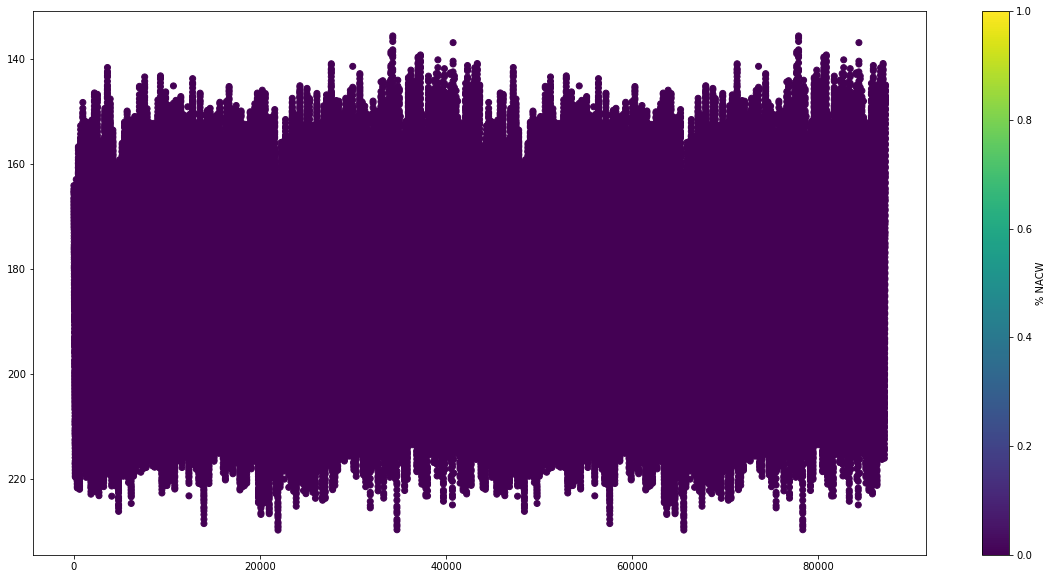

In [42]:
min_range = 0
max_range = len(CW_ompa_soln.obs_df)
#max_range=2000


plt.figure(figsize=(20,10))
plt.scatter(np.arange(min_range,max_range), CW_ompa_soln.obs_df.depth[min_range:max_range], c=CW_ompa_soln.endmember_fractions[min_range:max_range,2], vmin=0,vmax=1)
plt.gca().invert_yaxis()
plt.colorbar(label='% NACW')


## Test the mass conservation constraint

In [8]:
hardmasscons_settings = {
    "param_names": ["potential_temperature", "salinity",
                    "oxygen_concentration", "mass"],
    "param_weightings": paramweightings,
    "convertedparam_groups": convertedparamgroups,
    #The difference here is that sumtooneconstraint is True
    "sumtooneconstraint": True,
     "standardize_by_watertypes": True
}


#Run the analysis with the hard mass conservation constraint
CW_hardmasscons_ompa_soln = pyompa.OMPAProblem(obs_df = CW_sci_gdf,**hardmasscons_settings).solve(central_waters_FK_endmemberdf, endmember_name_column = "endmember_name")



Dropping 969502 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('WSACW', [0]), ('ESACW', [1]), ('NACW', [2])])
I'm assuming that the index encoding mass is: [3]
Std used for normalization: [0.64645185 0.28827475 0.35118846 1.        ]
Mean used for normalization: [10.68       35.10733333  3.93333333  0.        ]
params to use: ['potential_temperature', 'salinity', 'oxygen_concentration', 'mass']
param weighting: [24. 24.  7. 24.]
effective weighting: [37.12573464 83.25390876 19.93231791 24.        ]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 945140 out of 945140
status: optimal
optimal value 37147468042.109436
Original weighted sum squares: 37147468042.109436
Post fix weighted sum squared: 37147473573.58324
On example 0 to 945140 out of 945140
status: optimal
optimal value 37147468042.109436
Original weighted sum squares: 37147468042.109436
Post fix weighted sum squared: 37147473573.58324
objective: 37147473573.58318


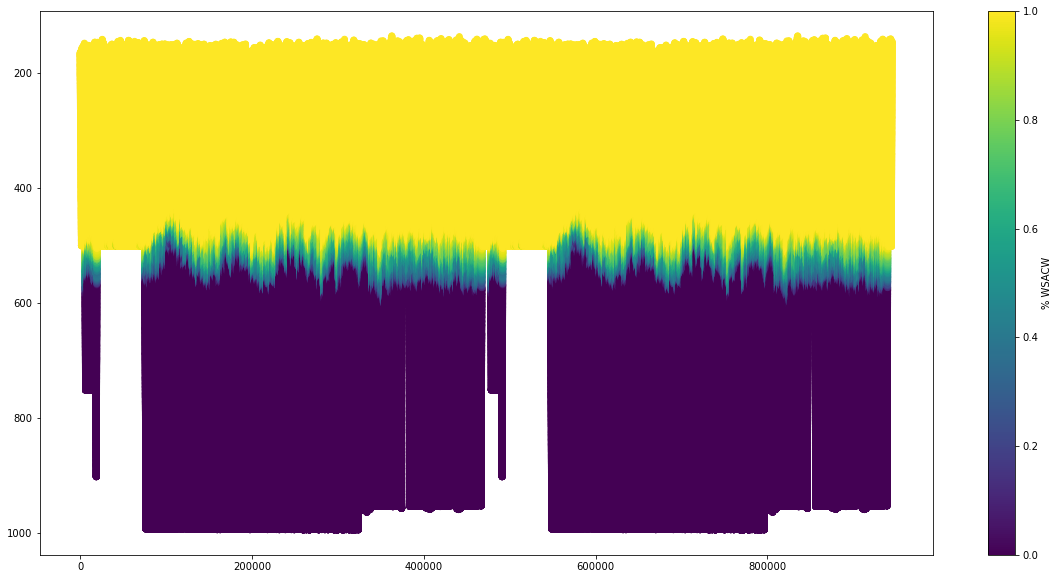

In [10]:
min_range = 0
max_range = len(CW_hardmasscons_ompa_soln.obs_df)
#max_range=2000


plt.figure(figsize=(20,10))
plt.scatter(np.arange(min_range,max_range), CW_hardmasscons_ompa_soln.obs_df.depth[min_range:max_range], c=CW_hardmasscons_ompa_soln.endmember_fractions[min_range:max_range,0], vmin=0,vmax=1)
plt.gca().invert_yaxis()
plt.colorbar(label='% WSACW')



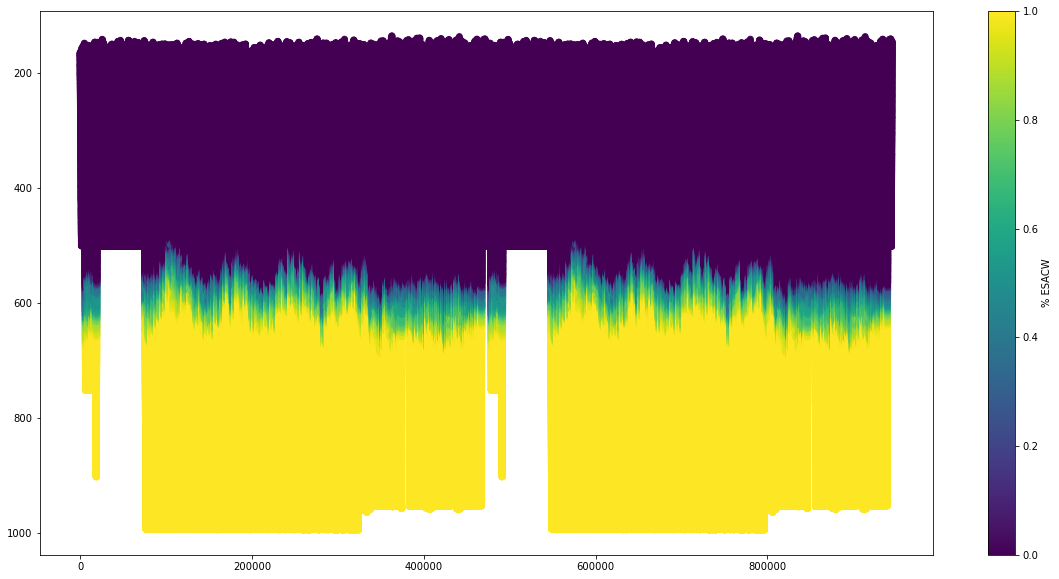

In [11]:
min_range = 0
max_range = len(CW_hardmasscons_ompa_soln.obs_df)
#max_range=2000


plt.figure(figsize=(20,10))
plt.scatter(np.arange(min_range,max_range), CW_hardmasscons_ompa_soln.obs_df.depth[min_range:max_range], c=CW_hardmasscons_ompa_soln.endmember_fractions[min_range:max_range,1], vmin=0,vmax=1)
plt.gca().invert_yaxis()
plt.colorbar(label='% ESACW')



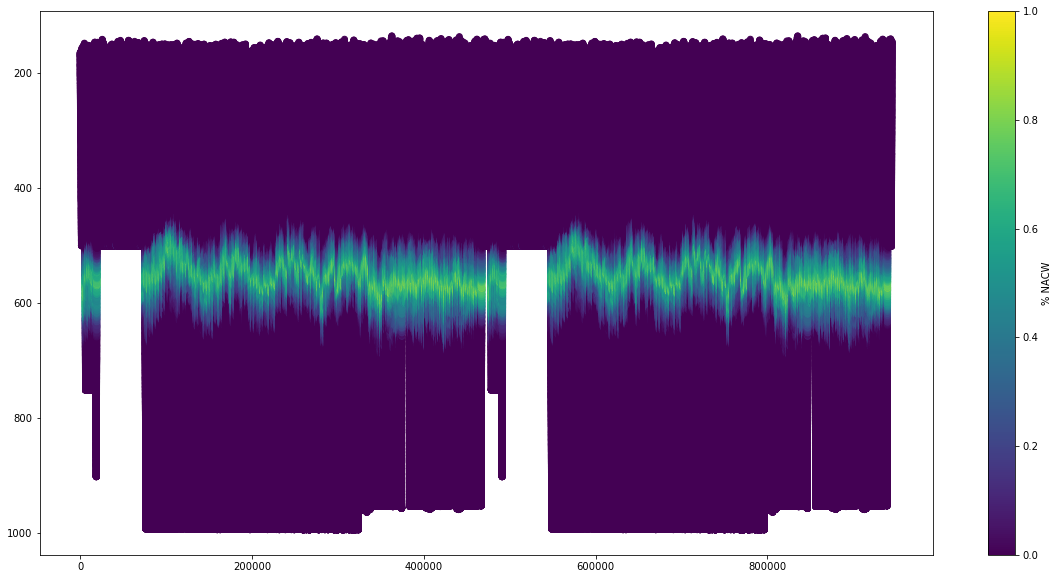

In [12]:
min_range = 0
max_range = len(CW_hardmasscons_ompa_soln.obs_df)
#max_range=2000


plt.figure(figsize=(20,10))
plt.scatter(np.arange(min_range,max_range), CW_hardmasscons_ompa_soln.obs_df.depth[min_range:max_range], c=CW_hardmasscons_ompa_soln.endmember_fractions[min_range:max_range,2], vmin=0,vmax=1)
plt.gca().invert_yaxis()
plt.colorbar(label='% NACW')

